In [1]:
#import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
#os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion",
        "SEI": "solvent-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed",
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "none"),
    }
)

In [3]:
chemistry = pybamm.parameter_sets.OKane2022
param = pybamm.ParameterValues(chemistry=chemistry)
param.update({"Upper voltage cut-off [V]": 4.21})
param.update({"Lower voltage cut-off [V]": 2.49})
param.update({"Negative electrode cracking rate": 1.95e-18})

In [4]:
total_cycles=1000
exp = pybamm.Experiment([
    "Hold at 4.2V until C/100", "Rest for 4 hours (5 minute period)", "Discharge at C/10 until 2.5V (5 minute period)", 
    "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"] + [(
    "Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)",
),]*total_cycles + ["Discharge at C/10 until 2.5V (5 minute period)"])

In [5]:
var_pts = {
    "x_n": 20,  # negative electrode
    "x_s": 20,  # separator 
    "x_p": 20,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [6]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts
)
solution1 = sim1.solve(calc_esoh=False)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

At t = 0.0210939 and h = 8.88573e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0072059 and h = 7.28808e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0256447 and h = 8.71229e-12, the corrector convergence failed repeatedly or with |h| = hmin.
2022-09-15 17:57:17.725 - [ERROR] callbacks.on_experiment_error(226): Simulation error: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


running time: 4943.808413000001s


In [7]:
path = '/mnt/c/Users/sokane/pybamm_data/OKane2022_verification/'

In [15]:
total_cycles=663
Q_previous = []
Q0 = solution1.cycles[0]["Discharge capacity [A.h]"].entries
Q0_delta = np.absolute(Q0[-1]-Q0[0])
Q2 = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Q2_delta = np.absolute(Q2[-1]-Q2[0])
Q3 = solution1.cycles[3]["Discharge capacity [A.h]"].entries
Q3_delta = np.absolute(Q3[-1]-Q3[0])
Q4 = solution1.cycles[4]["Discharge capacity [A.h]"].entries
Q4_delta = np.absolute(Q4[-1]-Q4[0])
Q_previous.append(Q0_delta+Q2_delta+Q3_delta+Q4_delta)
Q_throughput = []
Qdis_cycles = []
Qsei = []
Qsei_cracks = []
roughness_avg = []
roughness_sep = []
roughness_CC = []
porosity_avg = []
porosity_sep = []
porosity_CC = []
cs_neg_avg = []
cs_neg_sep = []
cs_neg_CC = []
cs_pos_avg = []
cs_pos_sep = []
cs_pos_CC = []
U_neg_avg = []
U_neg_sep = []
U_neg_CC = []
U_pos_avg = []
U_pos_sep = []
U_pos_CC = []
eta_SEI_avg = []
eta_SEI_sep = []
eta_SEI_CC = []
Lsei_avg = []
Lsei_sep = []
Lsei_CC = []
Lsei_cracks_avg = []
Lsei_cracks_sep = []
Lsei_cracks_CC = []
for i in range(total_cycles):
    Qdis = solution1.cycles[i+5].steps[0]["Discharge capacity [A.h]"].entries
    Qdis_delta = Qdis[-1] - Qdis[0]
    Qdis_cycles.append(Qdis_delta)
    Q_throughput.append(Q_previous[i]+Qdis_delta)
    Q_CC = solution1.cycles[i+5].steps[1]["Discharge capacity [A.h]"].entries
    Q_CC_delta = np.absolute(Q_CC[-1]-Q_CC[0])
    Q_CV = solution1.cycles[i+5].steps[2]["Discharge capacity [A.h]"].entries
    Q_CV_delta = np.absolute(Q_CV[-1]-Q_CV[0])
    Q_previous.append(Q_previous[i]+Qdis_delta+Q_CC_delta+Q_CV_delta)
    Qsei_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to SEI [mol]"].entries
    Qsei.append(Qsei_loc[-1] * 96485.3/3600)  #[Ah]
    Qsei_cracks_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to SEI on cracks [mol]"].entries
    Qsei_cracks.append(Qsei_cracks_loc[-1] * 96485.3/3600)  #[Ah]
    roughness_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode roughness ratio"].entries
    roughness_avg.append(roughness_avg_temp[-1])
    roughness_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode roughness ratio"].entries[-1,-1]
    roughness_sep.append(roughness_sep_temp)
    roughness_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode roughness ratio"].entries[0,-1]
    roughness_CC.append(roughness_CC_temp)
    poro_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode porosity"].entries
    porosity_avg.append(poro_avg_temp[-1])
    poro_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode porosity"].entries[-1,-1]
    porosity_sep.append(poro_sep_temp)
    poro_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode porosity"].entries[0,-1]
    porosity_CC.append(poro_CC_temp)
    cs_neg_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative particle surface concentration"].entries
    cs_neg_avg.append(cs_neg_avg_temp[-1])
    cs_neg_sep_temp = solution1.cycles[i+5].steps[0]["Negative particle surface concentration"].entries[-1,-1]
    cs_neg_sep.append(cs_neg_sep_temp)
    cs_neg_CC_temp = solution1.cycles[i+5].steps[0]["Negative particle surface concentration"].entries[0,-1]
    cs_neg_CC.append(cs_neg_CC_temp)
    cs_pos_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged positive particle surface concentration"].entries
    cs_pos_avg.append(cs_pos_avg_temp[-1])
    cs_pos_sep_temp = solution1.cycles[i+5].steps[0]["Positive particle surface concentration"].entries[0,-1]
    cs_pos_sep.append(cs_pos_sep_temp)
    cs_pos_CC_temp = solution1.cycles[i+5].steps[0]["Positive particle surface concentration"].entries[-1,-1]
    cs_pos_CC.append(cs_pos_CC_temp)
    U_neg_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode open circuit potential [V]"].entries
    U_neg_avg.append(U_neg_avg_temp[-1])
    U_neg_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode open circuit potential [V]"].entries[-1,-1]
    U_neg_sep.append(U_neg_sep_temp)
    U_neg_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode open circuit potential [V]"].entries[0,-1]
    U_neg_CC.append(U_neg_CC_temp)
    U_pos_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged positive electrode open circuit potential [V]"].entries
    U_pos_avg.append(U_pos_avg_temp[-1])
    U_pos_sep_temp = solution1.cycles[i+5].steps[0]["Positive electrode open circuit potential [V]"].entries[0,-1]
    U_pos_sep.append(U_pos_sep_temp)
    U_pos_CC_temp = solution1.cycles[i+5].steps[0]["Positive electrode open circuit potential [V]"].entries[-1,-1]
    U_pos_CC.append(U_pos_CC_temp)
    eta_SEI_temp = solution1.cycles[i+5].steps[0]["X-averaged SEI film overpotential [V]"].entries
    eta_SEI_avg.append(eta_SEI_temp[-1])
    eta_SEI_sep_temp = solution1.cycles[i+5].steps[0]["SEI film overpotential [V]"].entries[-1,-1]
    eta_SEI_sep.append(eta_SEI_sep_temp)
    eta_SEI_CC_temp = solution1.cycles[i+5].steps[0]["SEI film overpotential [V]"].entries[0,-1]
    eta_SEI_CC.append(eta_SEI_CC_temp)
    Lsei_temp = solution1.cycles[i+5].steps[0]["X-averaged total SEI thickness [m]"].entries
    Lsei_avg.append(Lsei_temp[-1])
    Lsei_sep_temp = solution1.cycles[i+5].steps[0]["Total SEI thickness [m]"].entries[-1,-1]
    Lsei_sep.append(Lsei_sep_temp)
    Lsei_CC_temp = solution1.cycles[i+5].steps[0]["Total SEI thickness [m]"].entries[0,-1]
    Lsei_CC.append(Lsei_CC_temp)
    Lcr_temp = solution1.cycles[i+5].steps[0]["X-averaged total SEI on cracks thickness [m]"].entries
    Lsei_cracks_avg.append(Lcr_temp[-1])
    Lcr_sep_temp = solution1.cycles[i+5].steps[0]["Total SEI on cracks thickness [m]"].entries[-1,-1]
    Lsei_cracks_sep.append(Lcr_sep_temp)
    Lcr_CC_temp = solution1.cycles[i+5].steps[0]["Total SEI on cracks thickness [m]"].entries[0,-1]
    Lsei_cracks_CC.append(Lcr_CC_temp)
M_cycles = np.array([Q_throughput,Qdis_cycles,Qsei,Qsei_cracks,
                     cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                     U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                     porosity_avg,porosity_sep,porosity_CC,
                     Lsei_avg,Lsei_sep,Lsei_CC,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                     Lsei_cracks_avg,Lsei_cracks_sep,Lsei_cracks_CC,roughness_avg,roughness_sep,roughness_CC,
                     
    ])
filename_cycles = path+'crack-SEI_50x_cycles.txt'
np.savetxt(filename_cycles,M_cycles,delimiter=",")

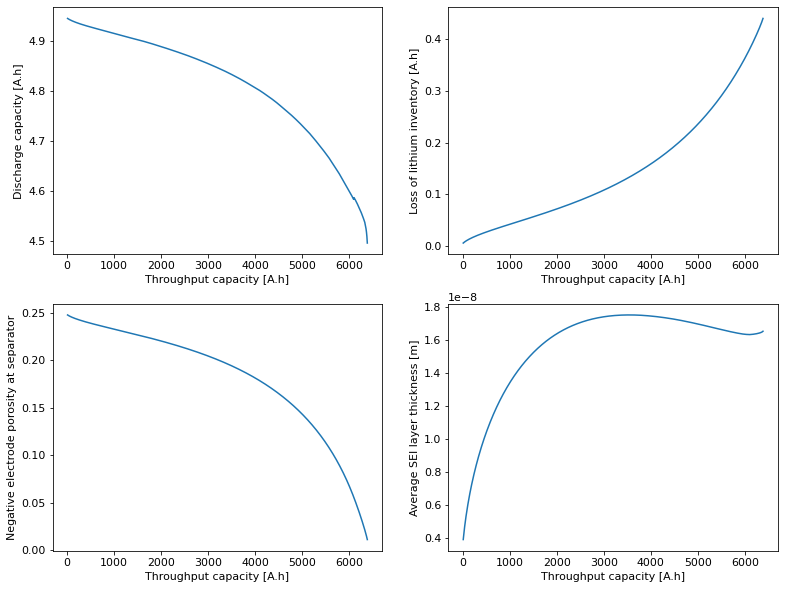

In [19]:
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(2, 2, figsize=(13,10))
axs[0,0].plot(Q_throughput,Qdis_cycles)
axs[0,0].set_xlabel("Throughput capacity [A.h]")
axs[0,0].set_ylabel("Discharge capacity [A.h]")
axs[0,1].plot(Q_throughput,np.add(Qsei,Qsei_cracks))
axs[0,1].set_xlabel("Throughput capacity [A.h]")
axs[0,1].set_ylabel("Loss of lithium inventory [A.h]")
axs[1,0].plot(Q_throughput,porosity_sep)
axs[1,0].set_xlabel("Throughput capacity [A.h]")
axs[1,0].set_ylabel("Negative electrode porosity at separator")
axs[1,1].plot(Q_throughput,np.divide(Lsei_avg+np.multiply(Lsei_cracks_avg,np.subtract(roughness_avg,1)),roughness_avg))
axs[1,1].set_xlabel("Throughput capacity [A.h]")
axs[1,1].set_ylabel("Average SEI layer thickness [m]")
plt.show()